# **Лабораторна робота №3**
### з дисципліни **"Інтелектуальні системи підтримки прийняття рішень"**

##### **За темою:** "Навчання регресiйної моделi градiєнтними методами в TensorFlow"

##### **Варіант:** 17

##### **Виконав:** Гавлицький Іван, КА-12

##### **Перевірила:** Недашкiвська Н.I.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import itertools

2024-05-21 13:51:14.607296: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 13:51:14.607394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 13:51:14.713077: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### **Хід виконання роботи:**
1. Завантажити початковi данi.
1. Представити данi графiчно.
1. Iнiцiалiзувати параметри: швидкiсть навчання, кiлькiсть епох (=100) i додатково, якщо задано згiдно з варiантом, кiлькiсть пакетiв i/або параметр регуляризацiї.
1. Iнiцiалiзувати вектор параметрiв.
1. Реалiзувати функцiю, яка задає модель **полiномiальної регресiї**.
1. Задати функцiю втрат **MSE з регуляризацiєю за нормами L1**.
1. Задати операцiю, яка буде викликатися на кожнiй iтерацiї **алгоритма мiнi-пакетного градiєнтного спуску**.
1. Виконати навчання моделi.
1. Виводити значення функцiї втрат через кожнi 10 епох.
1. Зберегти контрольнi точки через регулярнi iнтервали пiд час навчання. В кiнцi навчання зберегти результуючу модель. Вiдновити останню контрольну точку при запуску, якщо навчання було перервано.
1. Налаштувати гiперпараметр швидкiсть навчання i додатково, якщо задано згiдно варiанту, розмiр мiнi-пакета. Подивитися на форму кривої навчання.
1. Дослiдити рiзнi значення параметра регуляризацiї i пiдiбрати найкраще з них, якщо згiдно з варiантом задано регуляризовану функцiю втрат. В цьому випадку данi мають бути попередньо розбитi на навчальний та перевiрочний набори.
1. Побудувати графiк з початковими даними та лiнiєю регресiї.

## **Model initialization**

### Polynomial Regression

In [15]:
class PolynomialFeatures(tf.Module):
    def __init__(self, degree, name=None):
        super().__init__(name=name)
        self.degree = degree


    def __call__(self, X):
        batch_size, n_features = X.shape

        X_poly = []
        for d in range(1, self.degree + 1):
            items = list(itertools.combinations_with_replacement(range(n_features), d))
            X_poly.append(tf.math.reduce_prod(tf.gather(X, items, axis=1), axis=2))

        X_poly = self._minmax_scale(tf.concat(X_poly, axis=1))
        return tf.concat([tf.ones((batch_size, 1), dtype=X.dtype), X_poly], axis=1)
    
    
    def _minmax_scale(self, x):
        return (x - tf.reduce_mean(x, axis=0)) / tf.math.reduce_variance(x, axis=0)
    


class LinearRegression(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.weights = None


    def __call__(self, X):
        if self.weights is None:
            self.__build(X.shape)

        return X @ self.weights
    

    def __build(self, input_shape):
        w_temp = tf.random.normal([input_shape[-1], 1], dtype=tf.float64)
        self.weights = tf.Variable(w_temp, trainable=True, name='weights')
        
        
        
class PolynomialRegression(tf.Module):
    def __init__(self, degree, name=None):
        super().__init__(name=name)
        self.poly_features = PolynomialFeatures(degree)
        self.regression = LinearRegression()


    def __call__(self, X):
        X_poly = self.poly_features(X)
        return self.regression(X_poly)

### Loss function

In [3]:
def mean_squared_error(y_true, y_pred):
    return tf.reduce_mean((y_true - y_pred) ** 2)

def l1_regularization(weights):
    return tf.reduce_sum(tf.abs(weights))


def loss_function(model, X, y_true, l1_rate=0.01):
    y_pred = model(X)
    return mean_squared_error(y_true, y_pred) + l1_rate * l1_regularization(model.regression.weights)

### Training

In [4]:
def train_step(model, X, y_true, optimizer, l1_rate=0.01):
    with tf.GradientTape() as tape:
        loss = loss_function(model, X, y_true, l1_rate)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

In [125]:
def train_model(X, y, X_test, y_test, model, optimizer, epochs=200, batch_size=32, checkpoint_path=None, l1_rate=0.01):
    break_epoch = 0
    errors = np.zeros(epochs)
    test_errors = np.zeros(epochs)

    batch_errors = np.zeros(batch_size)
    
    dataset = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(X.shape[0], reshuffle_each_iteration=True)
    checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)

    if checkpoint_path:
        checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))


    for epoch in range(epochs):
        batch_ii = -1
        
        for X_batch, y_batch in dataset.batch(batch_size, drop_remainder=True):
            loss = train_step(model, X_batch, y_batch, optimizer, l1_rate)
            batch_errors[batch_ii := batch_ii+1] = loss
            
#             print(batch_ii)
#         print(list(batch_errors))
        errors[epoch] = batch_errors.mean()
        test_errors[epoch] = loss_function(model, X_test, y_test, l1_rate)
        
        if abs(errors[epoch] - errors[epoch-1]) < 1e-2:
            break_epoch = epoch
            break
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}: Loss: {errors[epoch]}")

            if checkpoint_path:
                checkpoint.save(file_prefix=checkpoint_path)

    return errors[:epoch+1], test_errors[:epoch+1]

## **Dataset A**

### **Data Loading**

In [6]:
dataset_a = {}

X_data = np.linspace(-1, 1, 101)

num_coef = 2
coef = [-1, 3]
y_data = 0

for ii in range(num_coef):
    y_data += coef[ii]*np.power(X_data, ii)

y_data += np.random.randn(*X_data.shape)*1.5

dataset_a['data'], dataset_a['target'] = X_data, y_data

In [7]:
dataset_a['data']

array([-1.  , -0.98, -0.96, -0.94, -0.92, -0.9 , -0.88, -0.86, -0.84,
       -0.82, -0.8 , -0.78, -0.76, -0.74, -0.72, -0.7 , -0.68, -0.66,
       -0.64, -0.62, -0.6 , -0.58, -0.56, -0.54, -0.52, -0.5 , -0.48,
       -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34, -0.32, -0.3 ,
       -0.28, -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16, -0.14, -0.12,
       -0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,  0.04,  0.06,
        0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,  0.22,  0.24,
        0.26,  0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,  0.4 ,  0.42,
        0.44,  0.46,  0.48,  0.5 ,  0.52,  0.54,  0.56,  0.58,  0.6 ,
        0.62,  0.64,  0.66,  0.68,  0.7 ,  0.72,  0.74,  0.76,  0.78,
        0.8 ,  0.82,  0.84,  0.86,  0.88,  0.9 ,  0.92,  0.94,  0.96,
        0.98,  1.  ])

In [8]:
dataset_a['target']

array([-3.43935873e+00, -3.40809933e+00, -6.13515673e+00, -4.95272858e+00,
       -4.39496793e+00, -2.00457350e+00, -5.89928678e+00, -2.66687966e+00,
       -2.89383532e+00, -1.40190146e+00, -3.69326031e+00, -3.50596597e+00,
       -4.97061125e+00, -4.08963299e+00,  1.27237021e-01, -2.65240153e+00,
       -3.19112399e+00, -2.72902381e+00, -1.12334459e-01,  1.37046312e+00,
       -2.06542052e+00, -3.41648169e+00, -7.15167201e-01, -1.06938725e+00,
       -3.18225188e+00, -2.95490147e+00,  6.08138259e-01, -1.19025249e+00,
       -4.98609479e+00, -1.65985327e+00, -8.25178823e-01, -3.37711370e+00,
       -9.67865531e-01, -3.79697976e+00, -1.03299727e+00, -1.45754679e+00,
        4.04567489e-01, -1.64799525e+00, -1.84427211e+00, -6.00477275e-01,
       -2.88634163e+00, -1.94113932e+00, -2.47207211e+00,  2.17645771e+00,
       -1.83519264e+00, -1.66375747e+00, -3.17682910e+00, -6.23220840e-01,
       -7.53224154e-01, -3.73715638e+00, -1.81843642e+00, -1.14353951e+00,
        2.91335938e-01,  

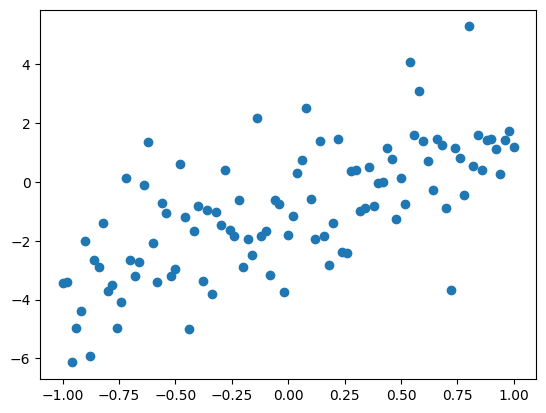

In [9]:
plt.scatter(dataset_a['data'], dataset_a['target'])
plt.show()

### Normalization

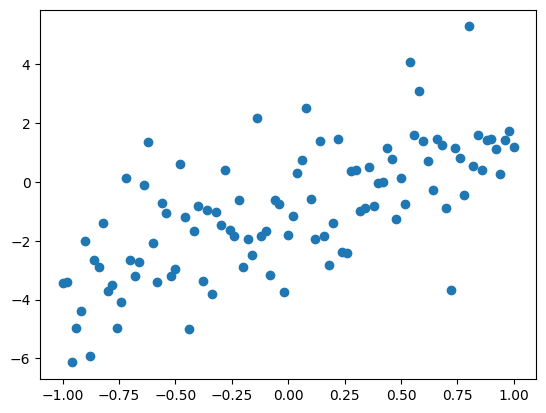

In [10]:
X, y = dataset_a['data'].reshape((-1, 1)), dataset_a['target'].reshape((-1, 1))
# X = (X - X.mean(axis=0)) / (X.max(axis=0) - X.min(axis=0))

plt.scatter(X, y)
plt.show()

### TrainTest split

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(f"Train features shape: {X_train.shape}, target shape: {y_train.shape}")
print(f"Test features shape: {X_test.shape}, target shape: {y_test.shape}")

Train features shape: (80, 1), target shape: (80, 1)
Test features shape: (21, 1), target shape: (21, 1)


In [12]:
def plot_ress(model, X_train, y_train, X_test, y_test, errors, test_errors):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Plot errors
    axs[0].plot(errors, label='Train Data')
    axs[0].plot(test_errors, label='Test Data')

    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Error')
    axs[0].set_title('Training Error')

    axs[0].legend()


    # Regression line
    axs[1].scatter(X_train, y_train, label='Train Data')
    axs[1].scatter(X_test, y_test, label='Test Data')
    axs[1].plot(X, model(X), color='red', label='Polynomial Regression Curve')

    axs[1].set_xlabel('x')
    axs[1].set_ylabel('y')
    axs[1].set_title('Polynomial Regression')

    axs[1].legend()

    plt.tight_layout()
    plt.show()

### Тренування та перевірка чекпоінтів

In [13]:
degree = 3

Зробимо перші 20 епох, аби перевірити чекпоінти

In [16]:
model = PolynomialRegression(degree=degree)
optimizer = tf.optimizers.SGD(learning_rate=0.01)

errors1, test_errors1 = train_model(X_train, y_train,
                     X_test, y_test,
                     model, optimizer,
                     epochs=20, batch_size=20,
                     checkpoint_path="/kaggle/working/dataset_a/",
#                      checkpoint_path=None,
                    )

Epoch 1: Loss: 11.744663965118695
Epoch 11: Loss: 0.5071677276759029


Продовжимо тренування

In [17]:
model = PolynomialRegression(degree=degree)
optimizer = tf.optimizers.SGD(learning_rate=0.01)

errors, test_errors = train_model(X_train, y_train,
                     X_test, y_test,
                     model, optimizer,
                     epochs=100, batch_size=20,
                     checkpoint_path="/kaggle/working/dataset_a/"
#                      checkpoint_path=None
                    )

Epoch 1: Loss: 0.504291807140583
Epoch 11: Loss: 0.4936520419172338
Epoch 21: Loss: 0.4406065973090028
Epoch 31: Loss: 0.49316422282961786
Epoch 41: Loss: 0.4255722136792654
Epoch 51: Loss: 0.45466306271624424
Epoch 61: Loss: 0.49672266871129045
Epoch 71: Loss: 0.4934118114574077
Epoch 81: Loss: 0.4279538825890805
Epoch 91: Loss: 0.42139737501007535
Epoch 101: Loss: 0.4335366258785035
Epoch 111: Loss: 0.48408730917581
Epoch 121: Loss: 0.4370784977080864
Epoch 131: Loss: 0.46442390942413425
Epoch 141: Loss: 0.4421374442895479
Epoch 151: Loss: 0.4861255539091429
Epoch 161: Loss: 0.44912541718776755
Epoch 171: Loss: 0.48647701636123697
Epoch 181: Loss: 0.4622239387477439
Epoch 191: Loss: 0.42361831669592903


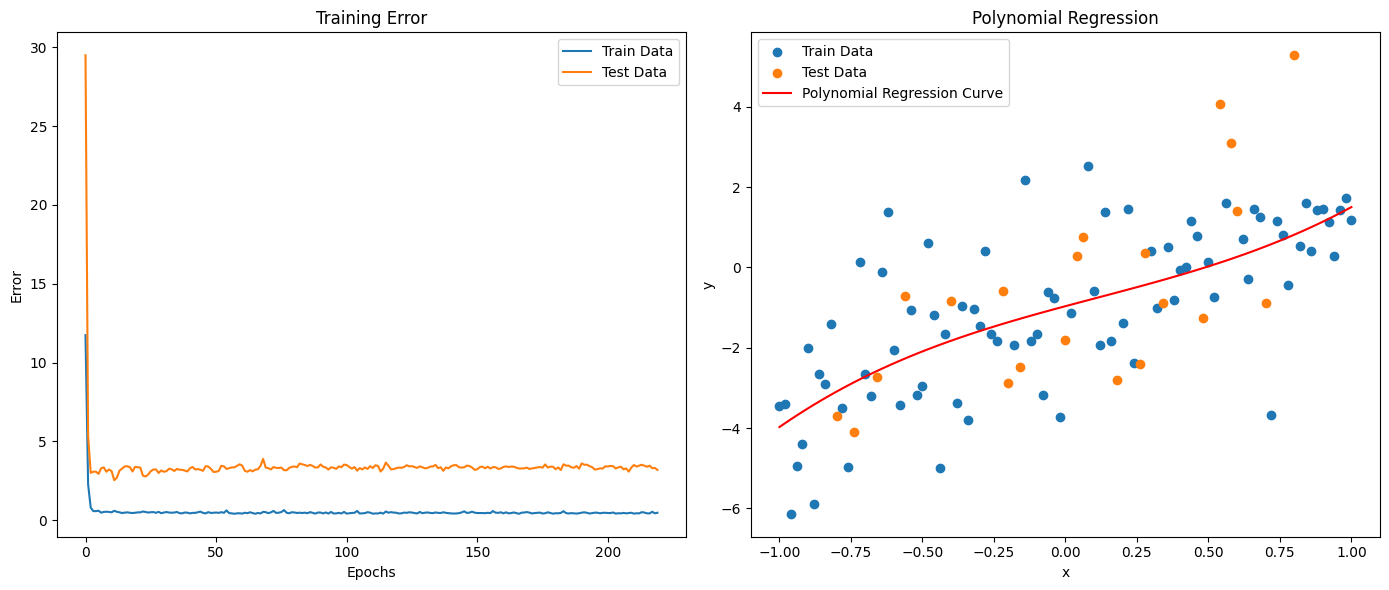

In [18]:
errors = np.concatenate([errors1, errors])
test_errors = np.concatenate([test_errors1, test_errors])

plot_ress(model, X_train, y_train, X_test, y_test, errors, test_errors)

Пограємося зі степеню полінома, параметром регуляризації та кроком навчання.

In [26]:
model = PolynomialRegression(degree=8)
optimizer = tf.optimizers.SGD(learning_rate=0.01)

errors, test_errors = train_model(X_train, y_train,
                                 X_test, y_test,
                                 model, optimizer,
                                 epochs=100, batch_size=20,
                                 checkpoint_path=None,
                                 l1_rate=0
                                )

Epoch 1: Loss: 14.641859769127445
Epoch 11: Loss: 1.455434936208779
Epoch 21: Loss: 0.9042287026593663
Epoch 31: Loss: 0.5666786496265421
Epoch 41: Loss: 0.5266559285930501
Epoch 51: Loss: 0.5780808687237482
Epoch 61: Loss: 0.6087159967805933
Epoch 71: Loss: 0.5179178400325327
Epoch 81: Loss: 0.5082523806787387
Epoch 91: Loss: 0.8630963214949497


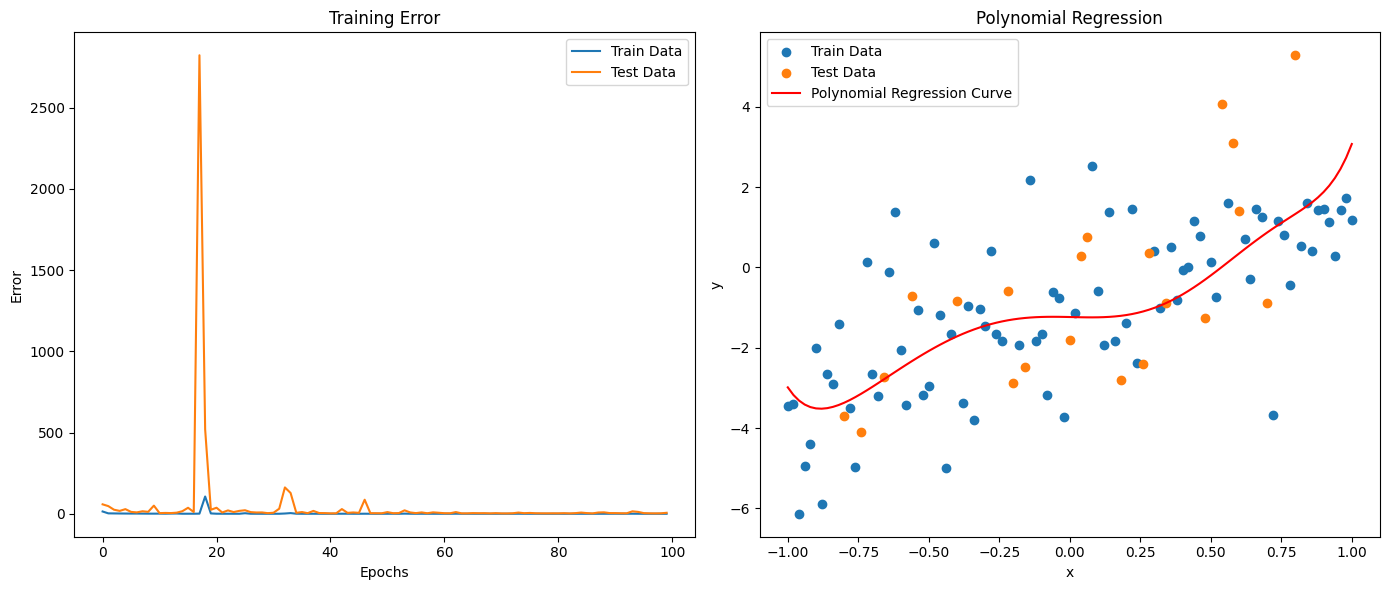

In [27]:
plot_ress(model, X_train, y_train, X_test, y_test, errors, test_errors)

>Вищенаведений приклад - один із небагатьох варіантів, коли вдалося досягти збіжності.

Випаравив ситуацію нормалізацією поліноміальний фічей.

Робив експерименти на першому датасеті, бо другий візуалізувати не вийде. Проте, за умови того, що дані згенеровано як пряма + шум, сенсу в поліноміальній регресії небагато. Перенавчання не спостерігаємо, крива намагається "прийти" до початкової прямої.

## **Dataset B**

### **Data Loading**

In [28]:
from sklearn.datasets import fetch_openml

dataset_b = fetch_openml(name='boston', version=1, parser='auto')

In [29]:
print(dataset_b.DESCR)

**Author**:   
**Source**: Unknown - Date unknown  
**Please cite**:   

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.
Variables in order:
CRIM     per capita crime rate by town
ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS    proportion of non-retail business acres per town
CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
NOX      nitric oxides concentration (parts per 10 million)
RM       average number of rooms per dwelling
AGE      proportion of owner-occupied units built prior to 1940
DIS      weighted distances to five Boston employment centres
RAD      index of accessibility to radial highways
TAX      full-value property-tax rate per $10

In [30]:
dataset_b['data']

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48


In [31]:
dataset_b['target']

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: MEDV, Length: 506, dtype: float64

### TrainTest split

In [107]:
from sklearn.model_selection import train_test_split

X, y = dataset_b['data'].to_numpy(dtype=np.float64), dataset_b['target'].to_numpy(dtype=np.float64).reshape((-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(f"Train features shape: {X_train.shape}, target shape: {y_train.shape}")
print(f"Test features shape: {X_test.shape}, target shape: {y_test.shape}")

Train features shape: (404, 2), target shape: (404, 1)
Test features shape: (102, 2), target shape: (102, 1)


### Тренування

За умови `learning_rate>0.01` я спостерігав розбіжність. Це за умови `degree=2`

In [126]:
model = PolynomialRegression(degree=2)
optimizer = tf.optimizers.SGD(learning_rate=0.01)

errors, test_errors = train_model(X_train, y_train,
                                 X_test, y_test,
                                 model, optimizer,
                                 epochs=100, batch_size=100,
            #                      checkpoint_path="/kaggle/working/dataset_a/"
                                 checkpoint_path=None,
#                                  l1_rate=0.0001
                                )

Epoch 1: Loss: 23.42479788987238
Epoch 11: Loss: 7.307439310952486
Epoch 21: Loss: 4.3365958058771925
Epoch 31: Loss: 3.59480021554699


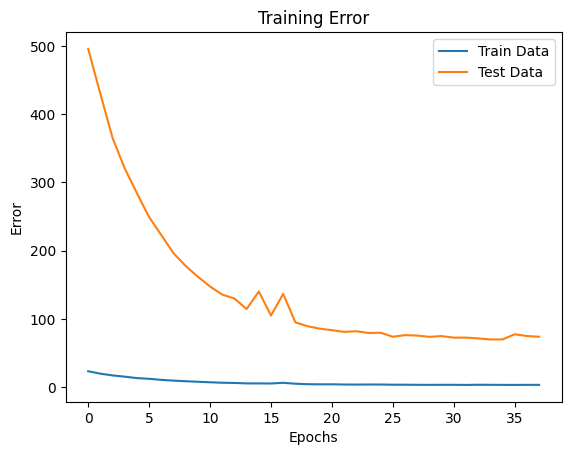

In [127]:
plt.plot(errors, label='Train Data')
plt.plot(test_errors, label='Test Data')

plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Training Error')

plt.legend()

Фінальна кількість епох обмежена через малу зміну значення функції втрат. Зробив це задля уникнення nan замість вагів. Причину відповідної поведінки я так і не знайшов, готовий списати це на розмірність (+ через поліноміальні ознаки вона сильно зросла).